
# Correlazioni & ML (v2): L1-CV, calibrazione probabilità, Precision-Recall

Notebook per analizzare correlazioni con `is_smelly`, e stimare l'importanza delle feature
con diversi modelli, includendo **Logistic Regression con L1-CV**, **calibrazione delle probabilità**
e **curva Precision-Recall**.


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

# Scegli dataset (v2 se disponibile, altrimenti originale)
DATA_CSV = "graph_hub_metrics_v2.csv"
if not os.path.exists(DATA_CSV):
    DATA_CSV = "graph_hub_metrics.csv"
assert os.path.exists(DATA_CSV), f"Non trovo {DATA_CSV}."

df = pd.read_csv(DATA_CSV)
print(df.shape)
df.head()


(2023, 24)


,file,is_smelly,n_nodes,n_edges,avg_in_deg,avg_out_deg,avg_tot_deg,gini_in_deg,gini_out_deg,gini_tot_deg,hhi_in_deg,hhi_out_deg,hhi_tot_deg,maxdeg_share,top3deg_share,max_over_median_deg,centr_in_deg,centr_out_deg,centr_tot_deg,centr_betweenness,thr_mu_plus_sigma_deg,num_hubs_arcade,ratio_hubs_arcade,largest_scc_ratio
0,opennlp-hl-23-24-25_762_0314_2012_7d91ff2e.pt,0.0,8.0,15.0,1.875000,1.875000,3.750000,0.441667,0.491667,0.250000,0.217778,0.280000,0.151111,0.233333,0.566667,2.000000,0.510204,0.836735,0.309524,0.047619,5.463914,1.0,0.125000,0.125000
1,commons-lang-hl-23-24-25_861_0146_7588_7e808a8...,1.0,11.0,26.0,2.363636,2.363636,4.727273,0.412587,0.503497,0.262238,0.147929,0.207101,0.113166,0.192308,0.461538,2.500000,0.510000,0.840000,0.322222,0.045000,7.066306,2.0,0.181818,0.090909
2,commons-lang-hl-23-24-25_1766_0114_7664_7d8433...,0.0,8.0,22.0,2.750000,2.750000,5.500000,0.420455,0.340909,0.193182,0.198347,0.181818,0.140496,0.204545,0.522727,1.800000,0.530612,0.693878,0.333333,0.190476,7.436492,1.0,0.125000,0.500000
3,commons-lang-hl-23-24-25_265_0536_8429_7d419b9...,0.0,9.0,28.0,3.111111,3.111111,6.222222,0.357143,0.404762,0.222222,0.163265,0.178571,0.128827,0.178571,0.482143,1.666667,0.687500,0.687500,0.303571,0.102679,8.706742,2.0,0.222222,0.333333
4,opennlp-hl-23-24-25_4665_0300_2065_6fde608c.pt,1.0,21.0,94.0,4.476190,4.476190,8.952381,0.422492,0.483283,0.283688,0.078316,0.095292,0.060208,0.106383,0.281915,2.500000,0.447500,0.815000,0.305263,0.132691,13.555446,3.0,0.142857,0.333333


## Feature numeriche e target

In [2]:

target_col = "is_smelly"
assert target_col in df.columns, "Manca la colonna is_smelly."

numeric_cols: List[str] = [c for c in df.columns if c != target_col and np.issubdtype(df[c].dtype, np.number)]
X = df[numeric_cols].copy()
y = df[target_col].astype(float).copy()

mask = ~X.isna().any(axis=1) & ~y.isna()
X = X[mask]
y = y[mask]

print("Features:", X.shape[1], "Righe:", X.shape[0])
X.head()


Features: 22 Righe: 2023


,n_nodes,n_edges,avg_in_deg,avg_out_deg,avg_tot_deg,gini_in_deg,gini_out_deg,gini_tot_deg,hhi_in_deg,hhi_out_deg,hhi_tot_deg,maxdeg_share,top3deg_share,max_over_median_deg,centr_in_deg,centr_out_deg,centr_tot_deg,centr_betweenness,thr_mu_plus_sigma_deg,num_hubs_arcade,ratio_hubs_arcade,largest_scc_ratio
0,8.0,15.0,1.875000,1.875000,3.750000,0.441667,0.491667,0.250000,0.217778,0.280000,0.151111,0.233333,0.566667,2.000000,0.510204,0.836735,0.309524,0.047619,5.463914,1.0,0.125000,0.125000
1,11.0,26.0,2.363636,2.363636,4.727273,0.412587,0.503497,0.262238,0.147929,0.207101,0.113166,0.192308,0.461538,2.500000,0.510000,0.840000,0.322222,0.045000,7.066306,2.0,0.181818,0.090909
2,8.0,22.0,2.750000,2.750000,5.500000,0.420455,0.340909,0.193182,0.198347,0.181818,0.140496,0.204545,0.522727,1.800000,0.530612,0.693878,0.333333,0.190476,7.436492,1.0,0.125000,0.500000
3,9.0,28.0,3.111111,3.111111,6.222222,0.357143,0.404762,0.222222,0.163265,0.178571,0.128827,0.178571,0.482143,1.666667,0.687500,0.687500,0.303571,0.102679,8.706742,2.0,0.222222,0.333333
4,21.0,94.0,4.476190,4.476190,8.952381,0.422492,0.483283,0.283688,0.078316,0.095292,0.060208,0.106383,0.281915,2.500000,0.447500,0.815000,0.305263,0.132691,13.555446,3.0,0.142857,0.333333


## Correlazioni con il target (Pearson & Spearman)

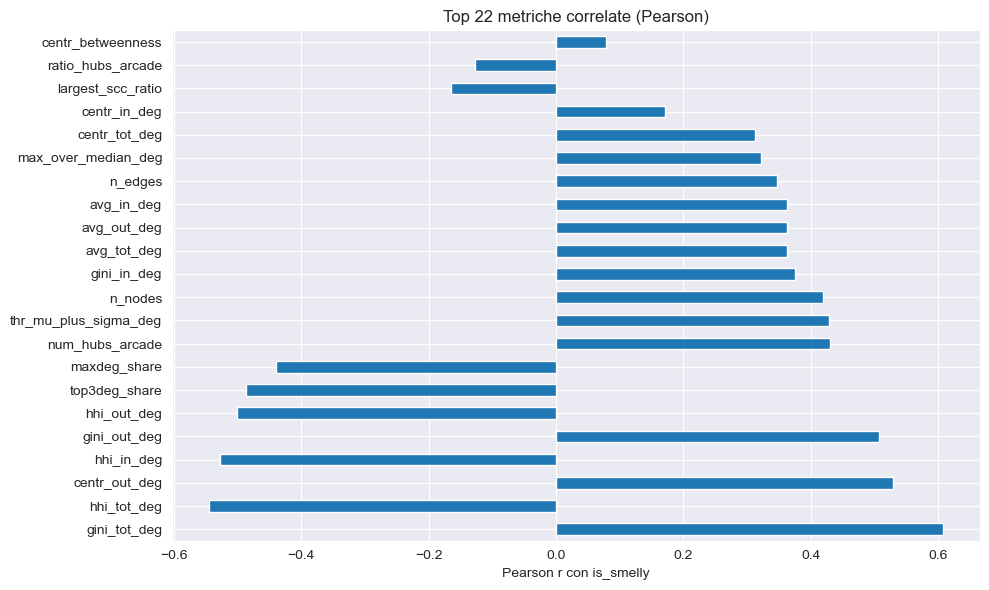

In [3]:

pearson_with_y = X.apply(lambda col: np.corrcoef(col, y)[0,1]).replace([np.inf,-np.inf], np.nan).fillna(0.0)
spearman_with_y = X.rank().corrwith(y.rank(method="average"), method="pearson").replace([np.inf,-np.inf], np.nan).fillna(0.0)

pearson_with_y.sort_values(key=np.abs, ascending=False).to_csv("corr_pearson_with_target_v2.csv", header=["pearson"])
spearman_with_y.sort_values(key=np.abs, ascending=False).to_csv("corr_spearman_with_target_v2.csv", header=["spearman"])

topn = min(25, len(pearson_with_y))
plt.figure(figsize=(10,6))
pearson_with_y.sort_values(key=np.abs).iloc[-topn:][::-1].plot(kind="barh")
plt.xlabel("Pearson r con is_smelly")
plt.title(f"Top {topn} metriche correlate (Pearson)")
plt.tight_layout()
plt.show()


## Train/Test split

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1517, 22) Test: (506, 22)


## Logistic Regression (L1) base

In [5]:

pipe_l1 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear", C=1.0, class_weight="balanced", max_iter=5000))
])
pipe_l1.fit(X_train, y_train)
proba_l1 = pipe_l1.predict_proba(X_test)[:,1]
pred_l1 = (proba_l1 >= 0.5).astype(float)
print("L1 Accuracy:", round(accuracy_score(y_test, pred_l1),4),
      "AUC:", round(roc_auc_score(y_test, proba_l1),4))
print(classification_report(y_test, pred_l1, digits=3))


L1 Accuracy: 0.834 AUC: 0.9404
              precision    recall  f1-score   support

         0.0      0.877     0.751     0.809       237
         1.0      0.805     0.907     0.853       269

    accuracy                          0.834       506
   macro avg      0.841     0.829     0.831       506
weighted avg      0.839     0.834     0.833       506



## Logistic Regression con L1-CV (selezione automatica di C)

L1-CV Accuracy: 0.8419 AUC: 0.9529
              precision    recall  f1-score   support

         0.0      0.855     0.797     0.825       237
         1.0      0.832     0.881     0.856       269

    accuracy                          0.842       506
   macro avg      0.843     0.839     0.840       506
weighted avg      0.843     0.842     0.841       506



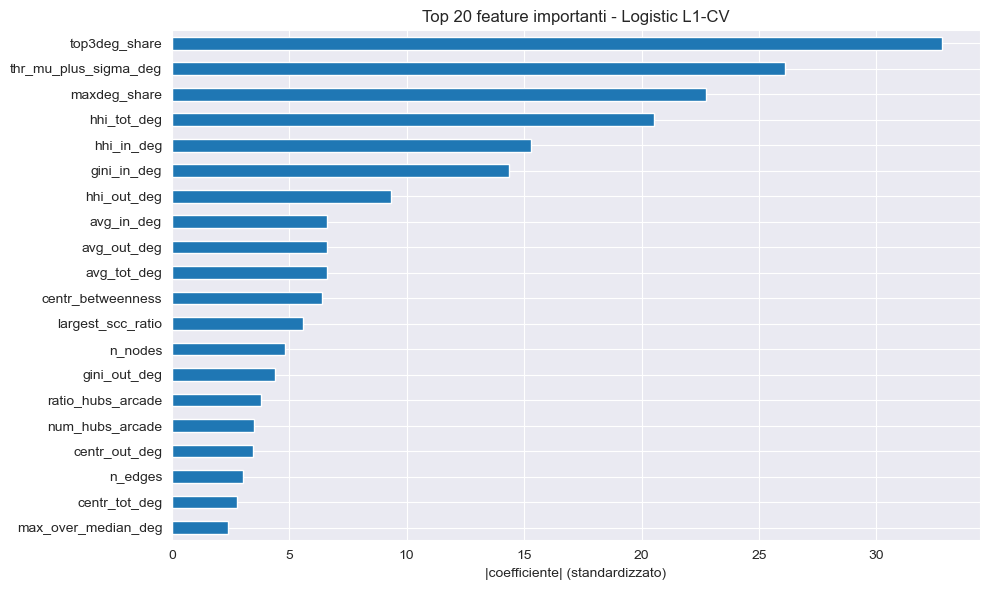

In [6]:

# Griglia di C su scala log
Cs_grid = np.logspace(-3, 2, 12)
pipe_l1cv = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=Cs_grid,
        cv=5,
        penalty="l1",
        solver="saga",
        class_weight="balanced",
        scoring="roc_auc",
        max_iter=5000,
        refit=True
    ))
])
pipe_l1cv.fit(X_train, y_train)
proba_l1cv = pipe_l1cv.predict_proba(X_test)[:,1]
pred_l1cv = (proba_l1cv >= 0.5).astype(float)
print("L1-CV Accuracy:", round(accuracy_score(y_test, pred_l1cv),4),
      "AUC:", round(roc_auc_score(y_test, proba_l1cv),4))
print(classification_report(y_test, pred_l1cv, digits=3))

# Importanza come |coef| (dopo standardizzazione)
coefs = pipe_l1cv.named_steps["clf"].coef_[0]
imp_l1cv = pd.Series(np.abs(coefs), index=X.columns).sort_values(ascending=False)
imp_l1cv.to_csv("logreg_l1cv_feature_importance.csv", header=["abs_coef"])

topn = min(20, len(imp_l1cv))
plt.figure(figsize=(10,6))
imp_l1cv.iloc[:topn][::-1].plot(kind="barh")
plt.xlabel("|coefficiente| (standardizzato)")
plt.title(f"Top {topn} feature importanti - Logistic L1-CV")
plt.tight_layout()
plt.show()


## Random Forest + calibrazione delle probabilità

In [7]:

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
cal_rf = CalibratedClassifierCV(rf, method="sigmoid", cv=5)  # calibrazione Platt
cal_rf.fit(X_train, y_train)

proba_rf_cal = cal_rf.predict_proba(X_test)[:,1]
pred_rf_cal = (proba_rf_cal >= 0.5).astype(float)
print("RF-Cal Accuracy:", round(accuracy_score(y_test, pred_rf_cal),4),
      "AUC:", round(roc_auc_score(y_test, proba_rf_cal),4))
print(classification_report(y_test, pred_rf_cal, digits=3))


RF-Cal Accuracy: 0.8557 AUC: 0.957
              precision    recall  f1-score   support

         0.0      0.860     0.827     0.843       237
         1.0      0.853     0.881     0.867       269

    accuracy                          0.856       506
   macro avg      0.856     0.854     0.855       506
weighted avg      0.856     0.856     0.856       506



## Curva Precision-Recall (test set)

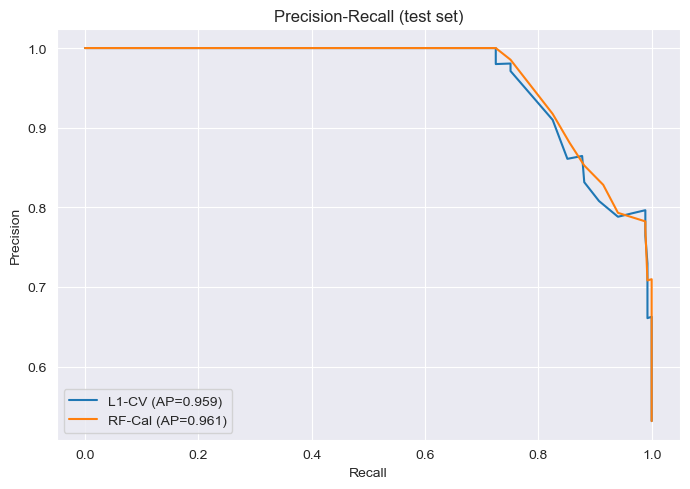

In [8]:

# PR curve per due modelli: Logistic L1-CV (non calibrato) vs RF calibrato
prec_l1cv, rec_l1cv, _ = precision_recall_curve(y_test, proba_l1cv)
ap_l1cv = average_precision_score(y_test, proba_l1cv)

prec_rf, rec_rf, _ = precision_recall_curve(y_test, proba_rf_cal)
ap_rf = average_precision_score(y_test, proba_rf_cal)

plt.figure(figsize=(7,5))
plt.plot(rec_l1cv, prec_l1cv, label=f"L1-CV (AP={ap_l1cv:.3f})")
plt.plot(rec_rf,   prec_rf,   label=f"RF-Cal (AP={ap_rf:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (test set)")
plt.legend()
plt.tight_layout()
plt.show()


## Curva di calibrazione (reliability diagram)

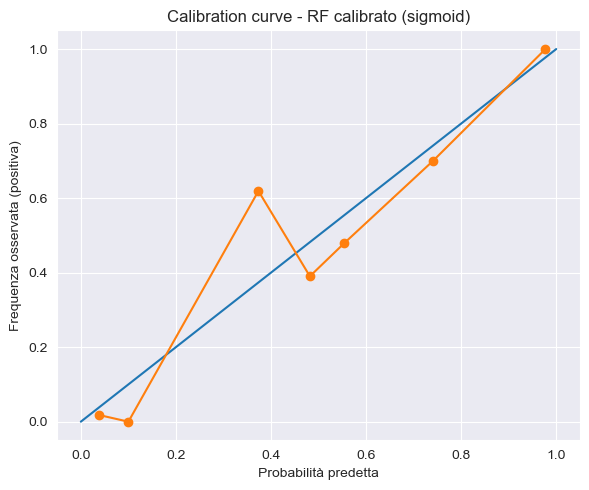

In [9]:

# Affidabilità delle probabilità (RF calibrato)
prob_true, prob_pred = calibration_curve(y_test, proba_rf_cal, n_bins=10, strategy="uniform")

plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1])  # perfetta calibrazione
plt.plot(prob_pred, prob_true, marker="o")
plt.xlabel("Probabilità predetta")
plt.ylabel("Frequenza osservata (positiva)")
plt.title("Calibration curve - RF calibrato (sigmoid)")
plt.tight_layout()
plt.show()
